# Knapsack Problem pt.2

Algoritmus resici dany jsem implementoval v C a vyuzil Makefile pro jednoduchou konfiguraci v compile time toho jake optimalizace chceme.

## Testovaci prostredi

Kod zkompilovan s tagem -O3, tedy nejvetsi stupen optimalizace (kompilatoru). Testy jsou provadeny pomoci scriptu `test.sh`, ktery spusti 10x stejne vstupy pro testovaci sady **NK**, **ZKW**, **ZKC**, velikost **15**, **20**, **22** pro verze **BNB**, **HEURISITC**, **REDUX** a **DP**($\epsilon\in[0.1, 0.2]$). Mereni casu probiha pomoci `/usr/bin/time`, ktery meri hodnoty celkovy cas behu (real), system overhead (sys) a cas samotneho algoritmu (user) v sekundach a vysledky jsou ulozeny do slozky results_2.

Ve vsech nasledujicich grafech a textech pracujeme s hodnotou _real_ co se tyce casu a chyba je merena v procentech vzhledem k vysledku **BNB** pro verze **HEURISITC**, **REDUX** a **DP**($\epsilon\in[0.1, 0.2]$). Testy byly spousteny na MacBook Pro (16-inch, 2019), macOS Big Sur 11.5.2 (20G95), 2.6 GHz 6-Core Intel Core i7 CPU, 16 GB 2667 MHz DDR4 RAM. Algoritmus nebyl optimalizovan pro praci na vice vlaknech.

## Popis algoritmu
### Heuristic
Algoritmus prochazi postupne predmety serazene podle pomeru $\frac{cena}{vaha}$ a pokousi se je vkladat. Pokud se predmet podari vlozit, tak postupuje na dalsi a nevetvi se (jako v pripade **BNB**), pokud se predmet nepodari vlozit, pak pokracuje. Jeho slozitost je tedy polynomialni.

### REDUX
Algoritmus funguje stejne jako **Heuristic**, akorat na konci porovna nalezene reseni s tim, kdyby v bathu byl pouze nejdrazsi predmet, ktery se do nej vejde.

### DP_E\<epsilon\>
Algoritmus vytvori tabulku o $n+1$ sloupcich a $m$ radcich, kde $n$ je pocet vstupnich predmetu a $m$ je celkova cena vsech predmetu. Nasledne pole vyplni podle predpisu uvedenych na teto strance: https://moodle-vyuka.cvut.cz/mod/page/view.php?id=153039 (Dekompozice podle ceny) a z vysledne tabulky zpetne hleda vysledek. Jeho slozitost je tedy $O(n*m)$. Parametr epsilon urcuje o kolik se proporcialne zmensi cena vsech predmetu, tedy i celkove ceny batohu a dojde tedy k snizeni casove slozitosti (za cenu ztraty presnosti). Prepocet predmetu probiha tak, ze se nejprve spocitat konstanta $k=\frac{cena\_nejdrazsiho\_predmetu * \epsilon}{n}$ a timto koeficientem se vydeli cena vsech predmetu. Tento prepocet probiha pouze v pripade ze $k>1$, protoze pro $k\leq1$ by doslo k zvyseni slozitosti a zaroven pokud $k\leq1$, pak vime ze cena nejdrazsiho predmetu bude maximalne $\frac{n}{\epsilon}$, coz pro nase vstupni data a testovane $\epsilon$ znamena, ze algoritmus pobezi dostatecne rychle. Samozrejme pro vstupy kde by bylo vice predmetu nez je cena nejdrazsiho predmetu a bylo by treba zvysit rychlost algoritmu by bylo treba pouzit jiny prepocet. **DP_E01** odpovida pouziti $\epsilon=0.1$, podobne s **DP_E02**.

## Inicializace prostredi, nacteni dat ze souboru

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
plt.rcParams['figure.figsize'] = (20, 5)

In [2]:
folder = "results_2"
dataset = ["NK", "ZKW", "ZKC"]
sizes = [15, 20, 22]

# Load Time File
def loadTimeFile(name):
    f = open(name, "r")
    inp = f.read().split("\n")

    real = {}
    user = {}
    sys = {}

    def getObj(t):
        if t == "real":
            return real
        if t == "user":
            return user
        if t == "sys":
            return sys

    index = ""
    for line in inp:
        if line == "":
            continue
        if "---" in line:
            index = line.split("---")[1].replace("-", "_")
            continue
        t, v = line.split()
        o = getObj(t)
        if not index in o:
            o[index] = []
        o[index].append(float(v))
    return (real, user, sys)

timeData = {}
for size in sizes:
    timeData[size] = {}
    for d in dataset:
        timeData[size][d] = loadTimeFile("{}/times_{}_{}.txt".format(folder, size, d))

In [3]:
types = ["BNB", "DP_E01", "DP_E02", "HEURISTIC", "REDUX"]

# Load Values File
def loadValuesFile(name):
    f = open(name, "r")
    inp = f.read().split("\n")
    res = []
    for line in inp:
        if line == "":
            continue
        res.append(int(line.split(" ")[2]))
    return res

valuesData = {}
for size in sizes:
    valuesData[size] = {}
    for d in dataset:
        valuesData[size][d] = {}
        for t in types:
            valuesData[size][d][t] = loadValuesFile("{}/result_{}_{}_{}.txt".format(folder, size, d, t))

In [4]:
errorData = {}
maxErrorData = {}
for size in sizes:
    errorData[size] = {}
    maxErrorData[size] = {}
    for d in dataset:
        reference = valuesData[size][d]["BNB"]
        errorData[size][d] = {}
        maxErrorData[size][d] = {}
        for t in types:
            if t == "BNB":
                continue
            errors = []
            measured = valuesData[size][d][t]
            for i, val in enumerate(measured):
                if reference[i] > 0 and val > 0:
                    errors.append(1-(val/(reference[i])))
            errorData[size][d][t] = np.average(errors)
            maxErrorData[size][d][t] = np.max(errors)

## Vyvoj v zavislosti na poctu predmetu v batohu

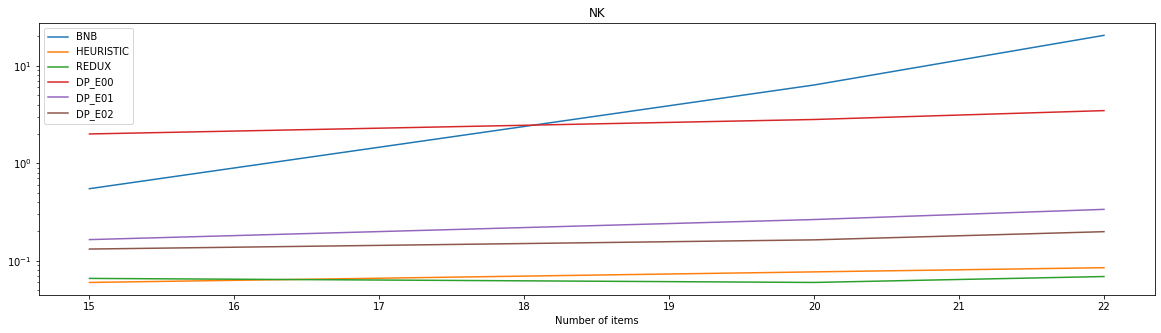

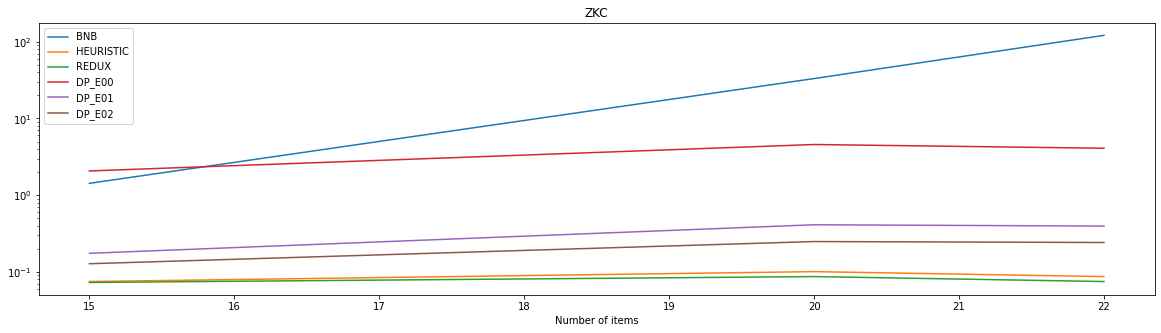

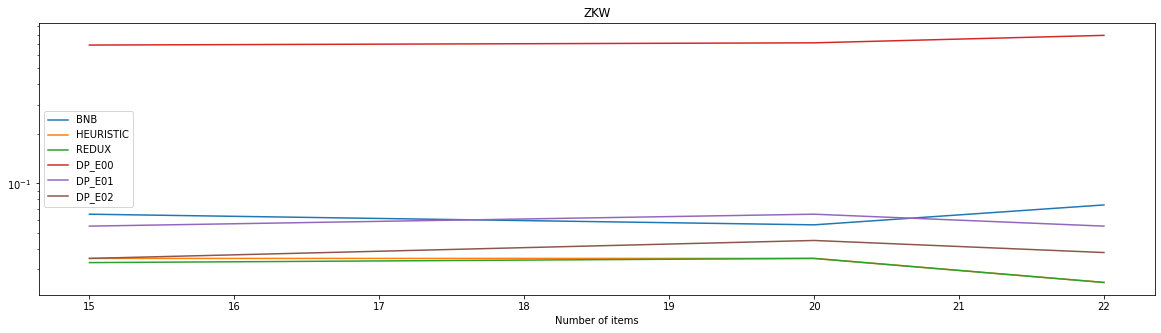

In [5]:
index = []
res = ({}, {}, {})
for d in timeData:
    index.append(d)
    times = timeData[d]["NK"][0]
    res[0][d] = {}
    for t in times:
        res[0][d][t] = np.mean(times[t])
    times = timeData[d]["ZKC"][0]
    res[1][d] = {}
    for t in times:
        res[1][d][t] = np.mean(times[t])
    times = timeData[d]["ZKW"][0]
    res[2][d] = {}
    for t in times:
        res[2][d][t] = np.mean(times[t])
df = pd.DataFrame(res[0]).transpose()
ax = df.plot(logy=True)
ax.set_xlabel("Number of items")
ax.set_title("NK")
plt.show()
df = pd.DataFrame(res[1]).transpose()
ax = df.plot(logy=True)
ax.set_xlabel("Number of items")
ax.set_title("ZKC")
plt.show()
df = pd.DataFrame(res[2]).transpose()
ax = df.plot(logy=True)
ax.set_xlabel("Number of items")
ax.set_title("ZKW")
plt.show()

Jak je videt z grafu (v logaritmickem meritku), pro **BNB** casova obtiznost stoupa nelinearne, zatimco vsechny ostatni verze se drzi na stejne urovni, jsou tedy polynomialni. Zaroven lze pozorovat ze varianty **DP_E00**, **DP_E01** a **DP_E02** maji obtiznost velmi podobnou, odsazenou o nejakou _konstantu_.

## Relativni chyba v korelaci s casem pro beh algoritmu

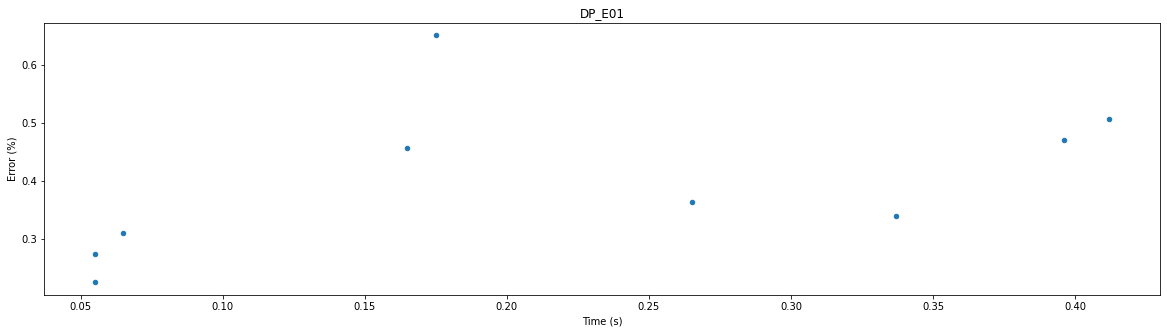

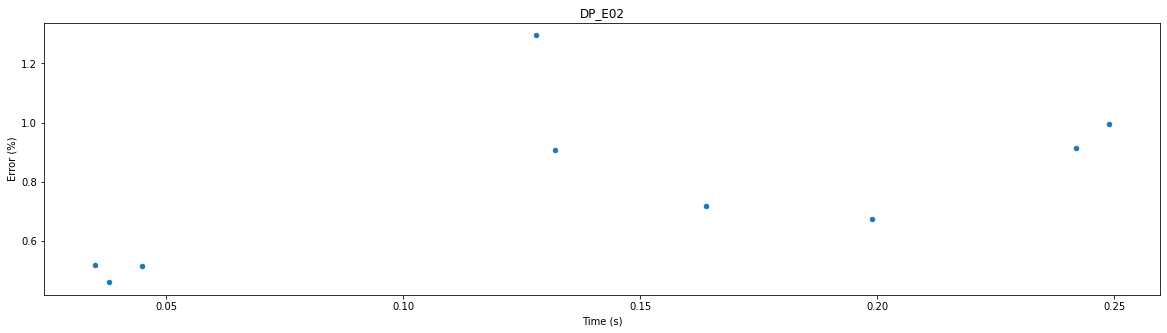

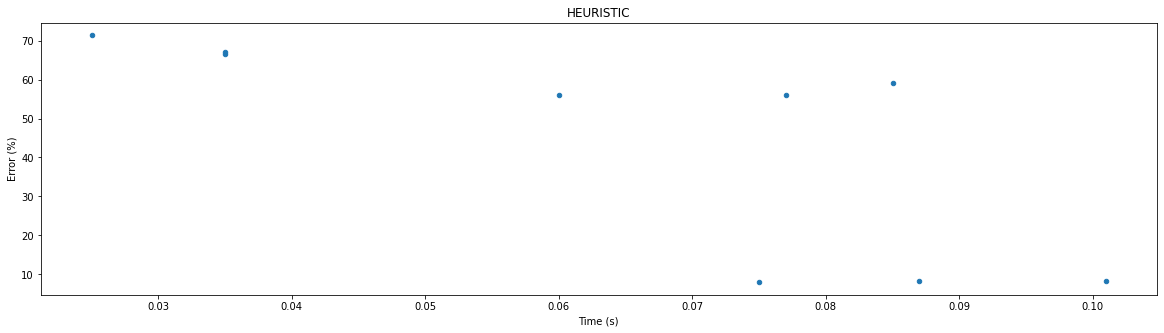

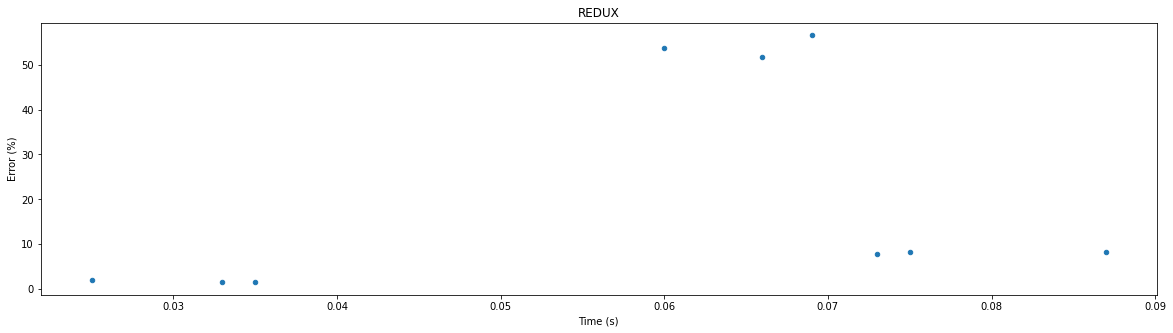

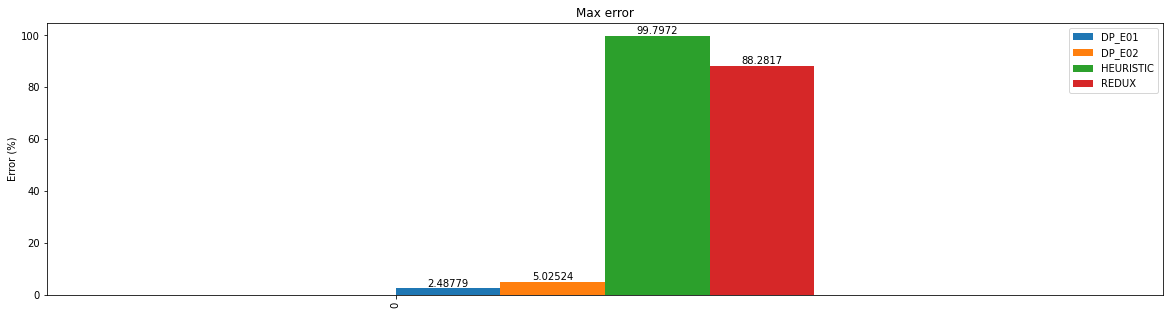

In [6]:
for t in types:
    if t != "BNB":
        res = []
        for d in timeData:
            for s in dataset:
                res.append((np.mean(timeData[d][s][0][t]), errorData[d][s][t]*100))
        df = pd.DataFrame(res)
        ax = df.plot.scatter(x=0, y=1, style='b')
        ax.set_title(t)
        ax.set_xlabel("Time (s)")
        ax.set_ylabel("Error (%)")
        plt.show()
maxErrorProcessed = {}
for size in maxErrorData:
    for d in maxErrorData[size]:
        for t in maxErrorData[size][d]:
            if t not in maxErrorProcessed:
                maxErrorProcessed[t] = 0
            maxErrorProcessed[t] = np.max([maxErrorProcessed[t], maxErrorData[size][d][t]*100])
df = pd.DataFrame(maxErrorProcessed, index=[0])
ax = df.plot.bar(align="edge", width=0.3)
for container in ax.containers:
    ax.bar_label(container)
ax.set_title("Max error")
ax.set_ylabel("Error (%)")
plt.show()

Z techto grafu je patrne, ze u variant **HEURISTIC** a **REDUX** je tezke odhadovat korelaci mezi vypocetni dobou a chybovosti. Jejich chyba se pohybuje mezi v podstate na cele skale a velmi zalezi na vstupnich datech. Naopak u **DP_E01** a **DP_E02** je videt ze chyba je primo zavisla na case, zaroven lze pozorovat s $\epsilon=0.2$ je chyba zhruba dvojnasobna oproti $\epsilon=0.1$ a zaroven zhruba o polovinu rychlejsi. Podobne to je i s maximalni chybou a to tak, ze varianta **HEURISTIC** muze dosahnout nepresnosti az $\thicksim99.8\%$ a varianta **REDUX** nikdy nemuze dosahnout horsiho vysledku nez **HEURISTIC**. Opet lze pozorovat ze maximalni chyba **DP_E02** je zhruba dvojnasobna oproti **DP_E01**, coz se shoduje s predchozim pozorovanim.

## Zaver

Z grafu casove slozitosti je zrejme ze zatimco algoritmus **BNB** je nepolynomialni, ostatni algoritmy odpovidaji polynomialnim casum. Zaroven vsak lze pozorovat ze pri spravne zvolenych vstupnich datech muze byt **BNB** rychlejsi nez ostatni a to diky spravnemu orezavani stavoveho prostoru (vstupni data _ZKW_) a diky absenci inicializace a naplnovani velkeho pole pro DP (_NK_ a _ZKC_ s velikosti 15).

Co se tyce prumerne chyby tak ta u algoritmu **HEURISTIC** presahuje $70\%$ a absolutni se blizi $99.8\%$, takze prestoze algoritmus dosahuje vzdy polynomialniho casu, tak vysledek muze byt daleko od idealniho. Algoritmus **REDUX** dosahuje nizsi jak prumerne, tak i maximalni chyby za cenu velmi zanedbatelneho casove zpomaleni. Algoritmus vyuzivajici dynamickeho programovani s dekompozici podle ceny s $\epsilon=0.1$ a $\epsilon=0.2$ bezel taktez v polynomialnim case, avsak znatelne pomaleji nez **HEURISTIC** a **REDUX**. U **DP_E01** a **DP_E02** lze pozorovat, ze rychlost, prumerna i absolutni chyba jsou primo zavisla na parametru $\epsilon$.